# Modeling

https://www.kaggle.com/code/apapiu/regularized-linear-models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_train=pd.read_csv('../data/train_cleaned_2.csv')
data_test=pd.read_csv('../data/test_cleaned_2.csv')

In [3]:
y=(data_train['SalePrice']) # price labels
y_log=np.log(data_train['SalePrice'])
data_train.drop(columns=['Id','SalePrice'],inplace=True)
data_test.drop(columns=['Id'],inplace=True)

In [4]:
data_train['MSSubClass']=data_train['MSSubClass'].astype('object')
data_test['MSSubClass']=data_test['MSSubClass'].astype('object')

## Data transformation
* sale price log transform
* scaling numerical features using StandartScaler
* dummy variables for the quantative data 

In [5]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

numeric_columns_train = data_train.select_dtypes(include=[np.number])
numeric_columns_test = data_test.select_dtypes(include=[np.number])

numeric_columns_train_transformed=scaler.fit_transform(numeric_columns_train)
numeric_columns_test_transformed=scaler.transform(numeric_columns_test)

In [6]:
object_columns_train = data_train.select_dtypes(include=['object'])
object_columns_test = data_test.select_dtypes(include=['object'])

object_columns_train_dummies=pd.get_dummies(object_columns_train)
object_columns_test_dummies=pd.get_dummies(object_columns_test)

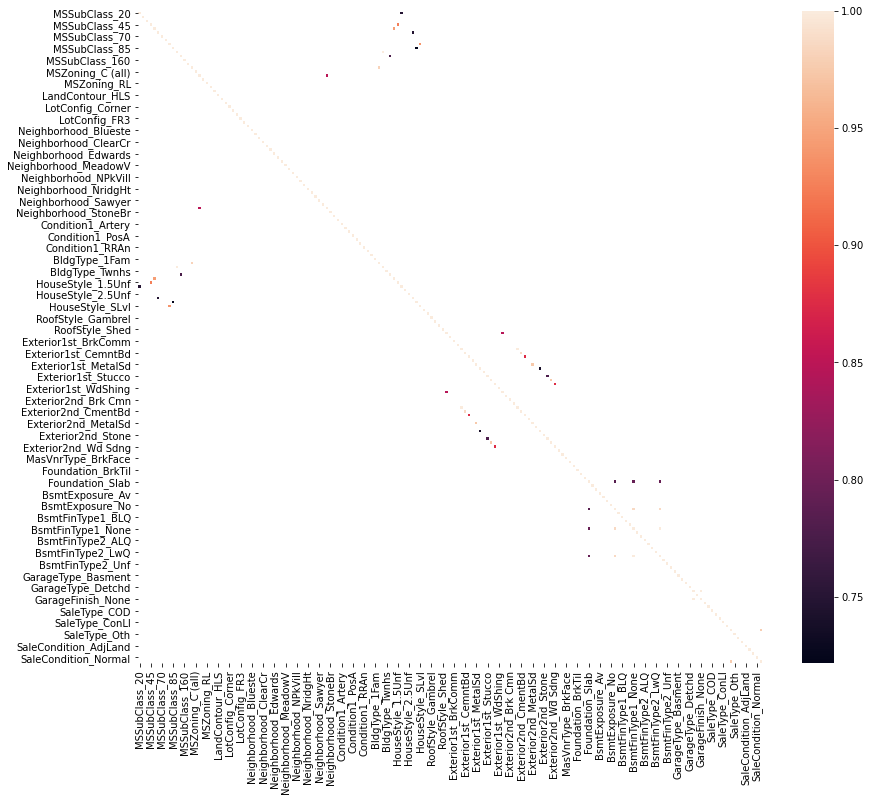

In [7]:
plt.figure(figsize=(14,12))
correlation = object_columns_train_dummies.corr()
sns.heatmap(correlation, mask = correlation <0.7, linewidth=0.5);

In [8]:
df_corr=correlation.unstack().reset_index()
df_corr.columns=['feature_1','feature_2','corr_coeff']
df_corr=df_corr[df_corr['feature_1']!=df_corr['feature_2']]


df_corr_high=df_corr[np.abs(df_corr['corr_coeff'])>0.7]
df_corr_high=df_corr_high.drop_duplicates(subset=['corr_coeff'])
df_corr_high

,feature_1,feature_2,corr_coeff
70,MSSubClass_20,HouseStyle_1Story,0.749010
570,MSSubClass_45,HouseStyle_1.5Unf,0.925087
736,MSSubClass_50,HouseStyle_1.5Fin,0.944673
908,MSSubClass_60,HouseStyle_2Story,0.746404
1411,MSSubClass_80,HouseStyle_SLvl,0.938176
1577,MSSubClass_85,HouseStyle_SFoyer,0.721554
1735,MSSubClass_90,BldgType_Duplex,1.000000
1904,MSSubClass_120,BldgType_TwnhsE,0.775369
2402,MSSubClass_190,BldgType_2fmCon,0.981587
2722,MSZoning_FV,Neighborhood_Somerst,0.848890


In [9]:
columns_to_drop=df_corr_high.feature_1
columns_to_drop.shape

(28,)

In [10]:
object_columns_train_dummies_clean=object_columns_train_dummies.drop(columns=columns_to_drop)
object_columns_test_dummies_clean=object_columns_test_dummies.drop(columns=columns_to_drop)

object_columns_train_dummies_clean.shape

(1276, 140)

In [11]:
class_proportion=object_columns_train_dummies_clean.sum(axis=0)/object_columns_train_dummies_clean.shape[0]
rare_class=list(class_proportion[class_proportion<0.10].index)

object_columns_train_dummies_c2=object_columns_train_dummies_clean.drop(columns=rare_class)

object_columns_test_dummies_c2=object_columns_test_dummies_clean.drop(columns=rare_class,errors='ignore')

## Select and train a Model

In [12]:
data_train_np=np.concatenate([numeric_columns_train_transformed,object_columns_train_dummies_c2.values],axis=1)
data_test_np=np.concatenate([numeric_columns_test_transformed,object_columns_test_dummies_c2.values],axis=1)

data=pd.concat([numeric_columns_train,object_columns_train_dummies_c2],axis=1)
columns_names=data.columns

In [13]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [14]:
X_train, X_test, y_train, y_test=train_test_split(data_train_np,y_log,test_size=0.3,shuffle=True,random_state=2022)

## Model Summary
#### Linear Regression
* Train MSE=0.13 R2=0.89 after outlier removal 0.90
* Test MSE=0.14 R2=0.86 after outlier removal 0.87

#### Ridge Regression
* Train MSE=0.13 R2=0.89 after outlier removal 0.90
* Test MSE=0.14 R2=0.86 after outlier removal 0.87


In [15]:
def calculate_model_metrics(model,X,y,note):
    y_pred=lin_reg.predict(X)
    model_mse=np.sqrt(mean_squared_error(y,y_pred))
    R2=r2_score(y,y_pred)
    print(note+" MSE={:.2f} R2={:.2f}".format(model_mse,R2))
    
    
def display_cross_val_scores(model,X_train,y_train,note):
    scores=cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
    rmse_scores=np.sqrt(-scores)
    
    print(note)
    print(rmse_scores)
    print('mean={}'.format(np.mean(rmse_scores)))
    print('std={}'.format(np.std(rmse_scores)))

In [16]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)

pd_coeff=pd.DataFrame(lin_reg.coef_,index=columns_names,columns=['coeff'])
# The coefficients
print("Coefficients: \n", pd_coeff.sort_values(by='coeff',ascending=False))
# intercept
print("Intercept ={}".format(lin_reg.intercept_))

calculate_model_metrics(lin_reg,X_train,y_train,"Train")
calculate_model_metrics(lin_reg,X_test,y_test,"Test")

display_cross_val_scores(lin_reg,X_train,y_train,'lin_reg')

Coefficients: 
                           coeff
FullBath           1.165682e+11
BsmtFullBath       1.124324e+11
HalfBath           1.098779e+11
2ndFlrSF           7.969481e+10
TotalBsmtSF        7.113246e+10
...                         ...
SaleType_WD       -6.645304e-02
HouseStyle_2Story -8.212662e-02
YrSold            -3.412077e+09
TotalSF           -9.043136e+10
TotalBaths        -1.940988e+11

[65 rows x 1 columns]
Intercept =11.931272555992626
Train MSE=0.11 R2=0.89
Test MSE=0.13 R2=0.87
lin_reg
[0.13379145 0.12153126 0.11706372 0.10348458 0.13953387]
mean=0.12308097700360769
std=0.0127125121201895


# Ridge

In [17]:
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
# The coefficients
print("Coefficients: \n", ridge_reg.coef_)
print("Intercept: \n", ridge_reg.intercept_)

calculate_model_metrics(ridge_reg,X_train,y_train,"Train")
calculate_model_metrics(ridge_reg,X_test,y_test,"Test")

display_cross_val_scores(ridge_reg,X_train,y_train,'ridge_reg')

Coefficients: 
 [ 0.01734345  0.01438348 -0.00639482  0.07806715  0.05148846  0.04845402
  0.00915993  0.00702252  0.01348265 -0.0040811  -0.01198122  0.02354447
 -0.00635622  0.04465523  0.01763164  0.02167872 -0.00149161 -0.00189137
  0.01538015  0.00478849 -0.01112424 -0.00318232  0.0134247   0.03844295
  0.02388016  0.01046578  0.03496619  0.00574249  0.00710794 -0.00142079
 -0.00417304 -0.00941866  0.05435357  0.01056748 -0.04576795 -0.01068689
 -0.00218998  0.00231641  0.00768454  0.03584067  0.02175802 -0.01454873
 -0.01378216 -0.05160388  0.00172772 -0.00138709  0.02082217 -0.00826662
 -0.00396279  0.0138216  -0.01486102  0.0455244  -0.02609096 -0.01733142
  0.00297161 -0.00822912  0.00131965 -0.01853008 -0.02971277  0.00233608
  0.03788332  0.03649691  0.02179423 -0.04882233  0.05635174]
Intercept: 
 11.936060159671655
Train MSE=0.11 R2=0.89
Test MSE=0.13 R2=0.87
ridge_reg
[0.13212603 0.12240344 0.11242388 0.10360302 0.13996513]
mean=0.12210430045480072
std=0.01308083972158966